<a href="https://colab.research.google.com/github/Samukelo789/Data-Science-Projects/blob/main/Fraud_Detection(Data_Science_Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn kaggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
if 'fraud_df' not in locals():
    print("Generating synthetic dataset for demo...")
    np.random.seed(42)
    n_samples = 10000
    n_fraud = 50  # Imbalanced
    time = np.random.uniform(0, 172800, n_samples)  # 2 days
    amount = np.random.lognormal(4, 2, n_samples)
    V_features = np.random.randn(n_samples, 28) * 2
    fraud_indices = np.random.choice(n_samples, n_fraud, replace=False)
    V_features[fraud_indices] += np.random.randn(n_fraud, 28) * 3
    amount[fraud_indices] *= np.random.uniform(5, 20, n_fraud)
    class_label = np.zeros(n_samples)
    class_label[fraud_indices] = 1
    fraud_df = pd.DataFrame(np.column_stack([time, V_features, amount, class_label]),
                            columns=['Time'] + [f'V{i}' for i in range(1, 29)] + ['Amount', 'Class'])
    print("Synthetic Fraud Dataset Shape:", fraud_df.shape)

print("\nFirst 5 rows:")
print(fraud_df.head())
print("\nDataset Info:")
print(fraud_df.info())
print("\nTarget Distribution:")
print(fraud_df['Class'].value_counts(normalize=True))

Generating synthetic dataset for demo...
Synthetic Fraud Dataset Shape: (10000, 31)

First 5 rows:
            Time        V1        V2        V3        V4        V5        V6  \
0   64720.532537 -1.232296 -0.785349 -2.063653 -1.778504  0.868754  0.263231   
1  164283.432148  4.192323 -0.957393 -2.307319 -0.187243  1.815721  0.034828   
2  126488.553145  2.792931 -4.154319  1.594505 -3.078110  2.456655 -1.274051   
3  103448.186069  2.189147  2.265684  2.210628  0.089004 -1.432389  0.382725   
4   26960.021068  3.307270 -1.069502 -0.376974 -0.822560 -1.343021 -3.682989   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.983173  0.428029  1.408677  ... -3.731680  0.056938  1.958072 -1.286308   
1  0.971188 -1.743021  2.975377  ... -1.394063  0.569679  2.281926  0.903325   
2 -2.435343  1.390538  0.728340  ...  4.036193 -2.375202  2.382470  2.141715   
3  1.884460  2.048704 -0.859352  ...  1.499110 -0.548223 -3.442094 -1.964832   
4 -0.029495 -2.57113

                Time            V1            V2            V3            V4  \
count   10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    85390.771568      0.014384     -0.004632      0.026312     -0.020152   
std     49702.485864      2.015058      2.000100      2.011361      2.012953   
min         2.010486     -9.395767     -8.965996     -7.310173     -8.666092   
25%     42565.628556     -1.338141     -1.350477     -1.332756     -1.383964   
50%     85108.945081      0.019739     -0.011888      0.011265      0.007982   
75%    127873.096984      1.367924      1.308693      1.394806      1.332543   
max    172751.213944      8.166963      7.224326      7.953736      7.179229   

                 V5            V6            V7            V8            V9  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.027111     -0.007939      0.014930     -0.014301      0.011390   
std        2.006924      2.047897      2.0

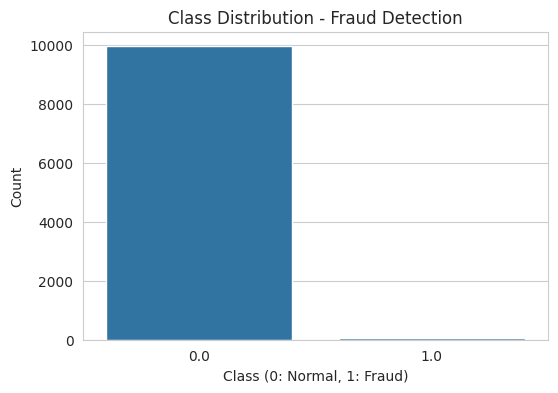

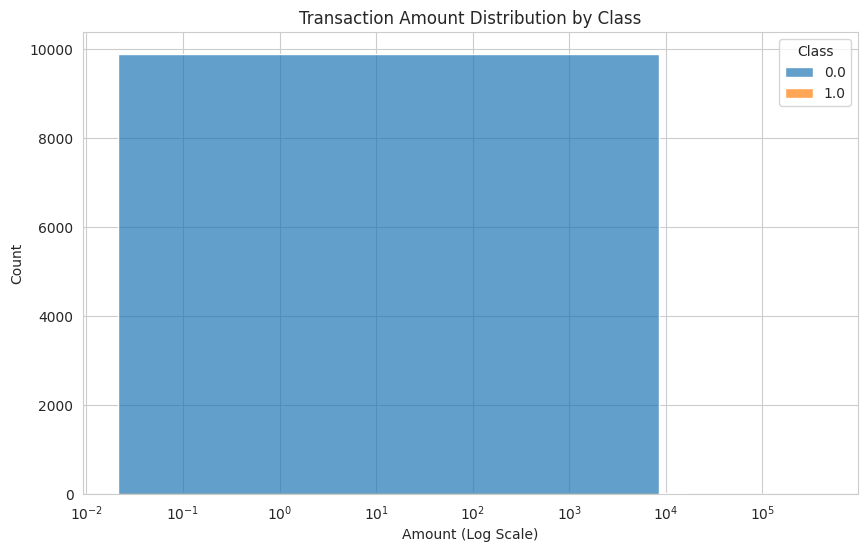

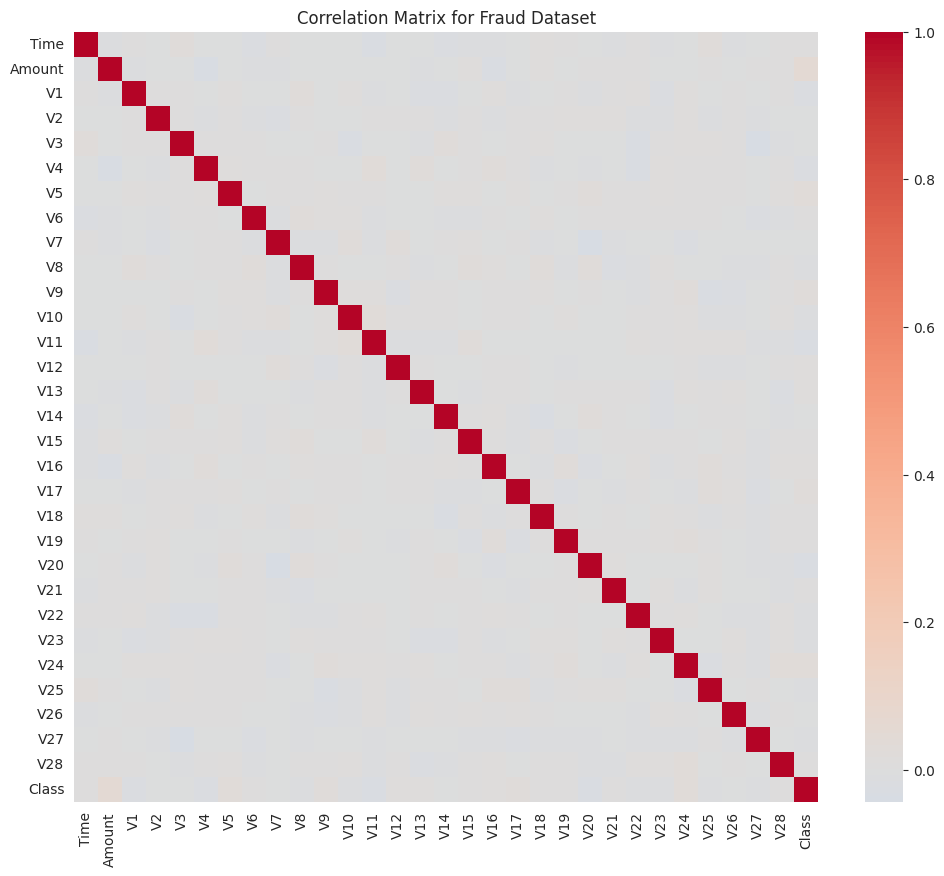

In [ ]:
print(fraud_df.describe())

# Imbalance plot
plt.figure(figsize=(6, 4))
sns.countplot(data=fraud_df, x='Class')
plt.title('Class Distribution - Fraud Detection')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Count')
plt.show()

# Distribution by class
plt.figure(figsize=(10, 6))
sns.histplot(data=fraud_df, x='Amount', hue='Class', bins=50, alpha=0.7)
plt.title('Transaction Amount Distribution by Class')
plt.xscale('log')
plt.xlabel('Amount (Log Scale)')
plt.show()

# Heatmap
numeric_cols = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)]
corr_subset = fraud_df[numeric_cols + ['Class']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_subset, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Fraud Dataset')
plt.show()

In [ ]:
# Split
X_fraud = fraud_df.drop('Class', axis=1)
y_fraud = fraud_df['Class']

# Train-test split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud)

# Scale features
scaler_f = StandardScaler()
X_train_f_scaled = scaler_f.fit_transform(X_train_f)
X_test_f_scaled = scaler_f.transform(X_test_f)

print("Preprocessed Data Shape - Train:", X_train_f_scaled.shape, "Test:", X_test_f_scaled.shape)
print("Train Class Distribution:", pd.Series(y_train_f).value_counts(normalize=True))
print("Test Class Distribution:", pd.Series(y_test_f).value_counts(normalize=True))

Preprocessed Data Shape - Train: (8000, 30) Test: (2000, 30)
Train Class Distribution: Class
0.0    0.995
1.0    0.005
Name: proportion, dtype: float64
Test Class Distribution: Class
0.0    0.995
1.0    0.005
Name: proportion, dtype: float64


Logistic Regression Results:
Accuracy: 0.792
AUC-ROC: 0.46824120603015074

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.79      0.88      1990
         1.0       0.01      0.30      0.01        10

    accuracy                           0.79      2000
   macro avg       0.50      0.55      0.45      2000
weighted avg       0.99      0.79      0.88      2000



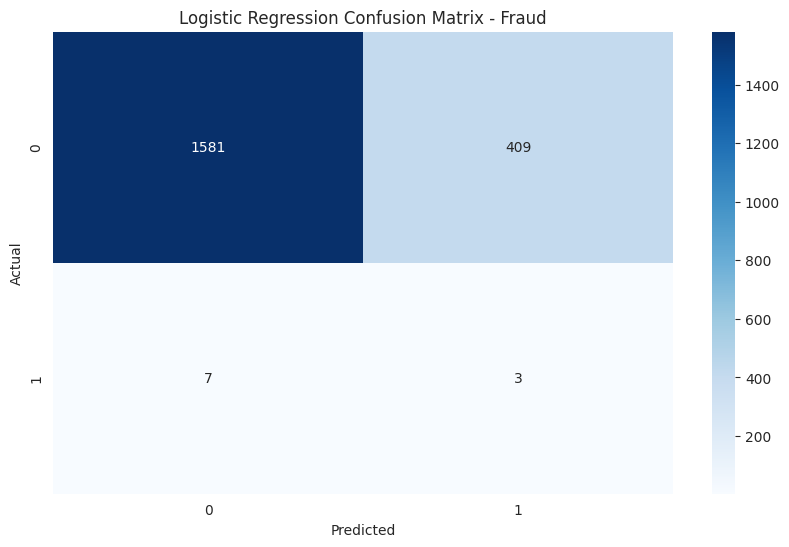


Random Forest Results:
Accuracy: 0.995
AUC-ROC: 0.898643216080402

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1990
         1.0       0.00      0.00      0.00        10

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      0.99      0.99      2000



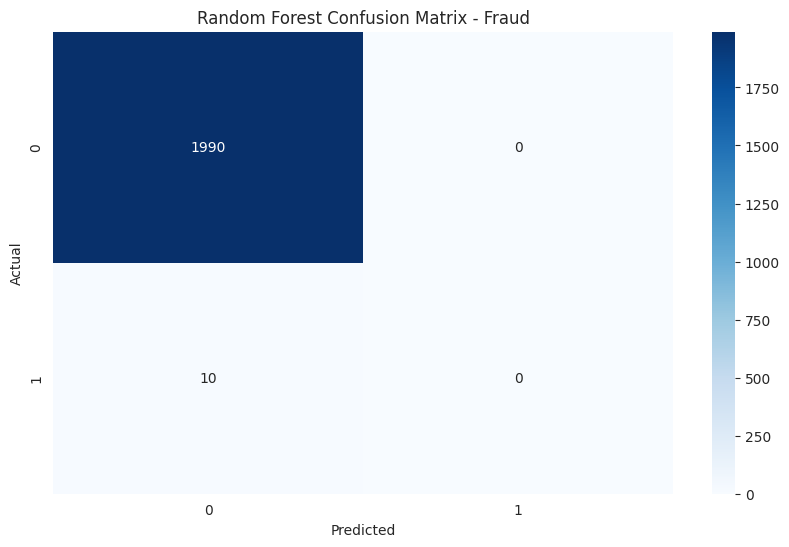

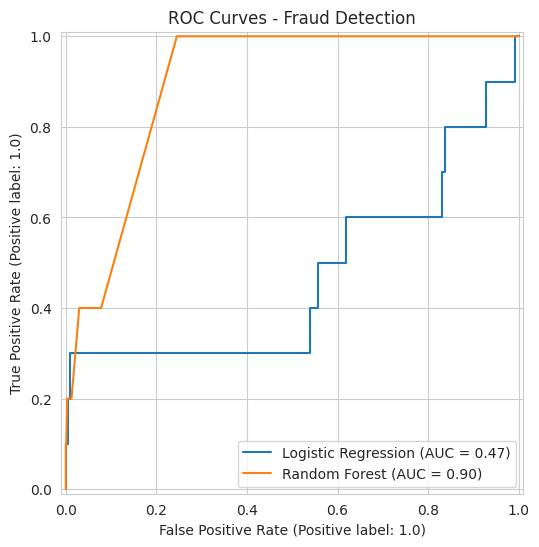

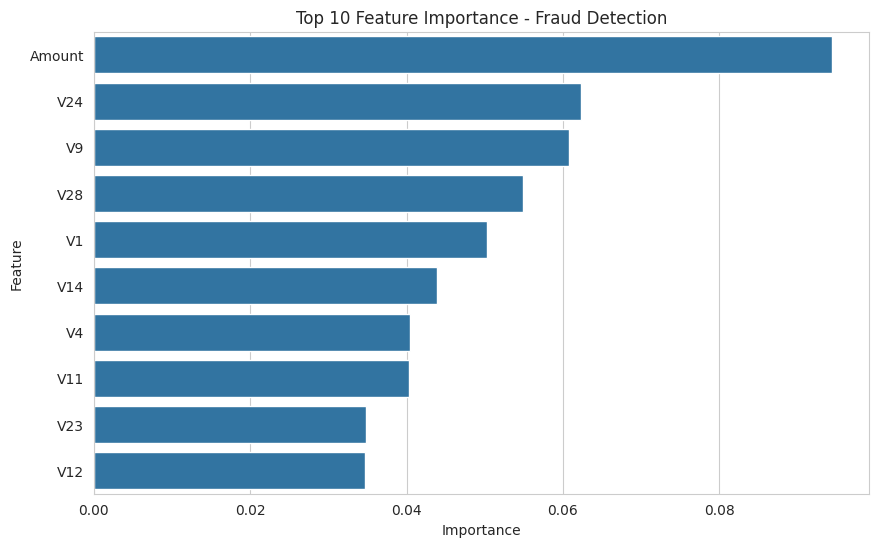

In [ ]:
smote = SMOTE(random_state=42)
X_train_f_res, y_train_f_res = smote.fit_resample(X_train_f_scaled, y_train_f)

# Logistic Regression
lr_f = LogisticRegression(random_state=42, max_iter=1000)
lr_f.fit(X_train_f_res, y_train_f_res)
y_pred_lr_f = lr_f.predict(X_test_f_scaled)
y_prob_lr_f = lr_f.predict_proba(X_test_f_scaled)[:, 1]
auc_lr_f = roc_auc_score(y_test_f, y_prob_lr_f)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test_f, y_pred_lr_f))
print("AUC-ROC:", auc_lr_f)
print("\nClassification Report:\n", classification_report(y_test_f, y_pred_lr_f))

cm_lr_f = confusion_matrix(y_test_f, y_pred_lr_f)
sns.heatmap(cm_lr_f, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix - Fraud')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Random Forest
rf_f = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_f.fit(X_train_f_scaled, y_train_f)
y_pred_rf_f = rf_f.predict(X_test_f_scaled)
y_prob_rf_f = rf_f.predict_proba(X_test_f_scaled)[:, 1]
auc_rf_f = roc_auc_score(y_test_f, y_prob_rf_f)

print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test_f, y_pred_rf_f))
print("AUC-ROC:", auc_rf_f)
print("\nClassification Report:\n", classification_report(y_test_f, y_pred_rf_f))

# Confusion Matrix
cm_rf_f = confusion_matrix(y_test_f, y_pred_rf_f)
sns.heatmap(cm_rf_f, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix - Fraud')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Curve for comparison
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(lr_f, X_test_f_scaled, y_test_f, ax=ax, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf_f, X_test_f_scaled, y_test_f, ax=ax, name="Random Forest")
plt.title('ROC Curves - Fraud Detection')
plt.show()

# Random Forest
feature_names_f = X_fraud.columns
importances_f = pd.DataFrame({'Feature': feature_names_f, 'Importance': rf_f.feature_importances_})
importances_f = importances_f.sort_values('Importance', ascending=False).head(10)
sns.barplot(data=importances_f, x='Importance', y='Feature')
plt.title('Top 10 Feature Importance - Fraud Detection')
plt.show()

In [ ]:
import joblib
joblib.dump(lr_f, 'logistic_regression_fraud.pkl')
joblib.dump(rf_f, 'random_forest_fraud.pkl')
joblib.dump(scaler_f, 'scaler_fraud.pkl')
print("Models and scaler saved for potential deployment.")

Models and scaler saved for potential deployment.
